# Linear Regression - Pytorch (From Scratch)

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu' # will select 'cuda' is gpu is available otherwise 'cpu'
print('Chosen device:', device)

Chosen device: cuda


## Creating the custom dataset.

`torch.randn` gives a tensor sampled from a normal distribution with mean of 0 and variance of 1

In [2]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def function(x):
    return 2 * x[:, 0] - 0.2 * x[:, 1] + 2.4

train_x = torch.randn(num_examples, num_inputs)
noise = 0.1 * torch.randn(num_examples,)
train_y = function(train_x) + noise

test_x = torch.randn(1000, num_inputs)
noise = 0.1 * torch.randn(1000)
test_y= function(test_x) + noise

print(train_x.shape)
print(train_y.shape)

print(test_x.shape)
print(test_y.shape)

torch.Size([10000, 2])
torch.Size([10000])
torch.Size([1000, 2])
torch.Size([1000])


## Visualizing training dataset

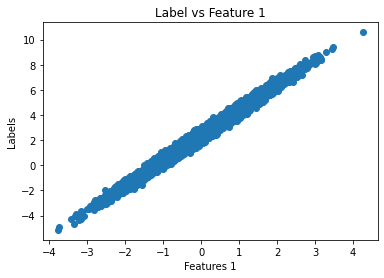

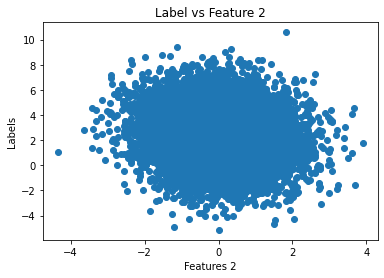

In [3]:
plt.scatter(train_x[:, 0], train_y)
plt.title('Label vs Feature 1')
plt.xlabel('Features 1')
plt.ylabel('Labels')
plt.show()

plt.scatter(train_x[:, 1], train_y)
plt.title('Label vs Feature 2')
plt.xlabel('Features 2')
plt.ylabel('Labels')
plt.show()

## Visualizing testing dataset

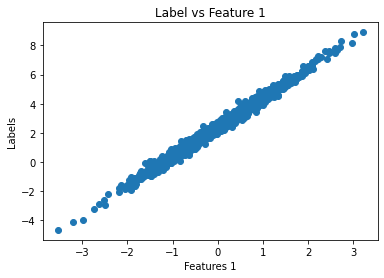

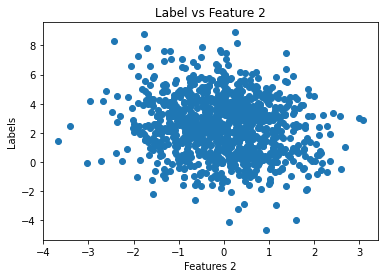

In [4]:
plt.scatter(test_x[:, 0], test_y)
plt.title('Label vs Feature 1')
plt.xlabel('Features 1')
plt.ylabel('Labels')
plt.show()

plt.scatter(test_x[:, 1], test_y)
plt.title('Label vs Feature 2')
plt.xlabel('Features 2')
plt.ylabel('Labels')
plt.show()

## Defining dataloader

In [5]:
batch_size = 16
dataset = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_x, train_y), batch_size = batch_size, shuffle = True)

print('No of batches for batch size {} is {}'.format(batch_size, len(dataset)))

No of batches for batch size 16 is 625


## Building Linear Regression Model

In pytorch, parameters can be declared using `torch.nn.Parameter`.

In [6]:
weights = nn.Parameter(torch.randn(num_inputs, num_outputs, device = device))
bias = nn.Parameter(torch.randn(num_outputs, device = device))
params = [weights, bias]

print(weights)
print(bias)

def linearregression(inputs):
    return torch.mm(inputs, weights) + bias # mm stands for matrix multiplication

Parameter containing:
tensor([[0.4956],
        [0.0814]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.5189], device='cuda:0', requires_grad=True)


## Defining our objective function

$\text{Mean Square Error} = \large\frac{1}{n}\sum_{i = 1}^{n}\left(\hat{y}_{i} - y_{i}\right)^2$,

In [7]:
def meansquare(predictions, labels):
    return torch.mean((predictions - labels) ** 2.0)

So one thing that's really different in pytorch is, when you do any kind of computation on the tensors which requires gradient computation, then pytorch automatically records all the computation for backward pass. That is, if I'd calculate `computed = 2 * weights`, then pytorch would have recorded the computation I've made with `weights` to compute `computed`, so to now to compute the gradients, we'd need to call `.backward()` method on the `computed`, and then we can get the gradients of the `weights` from its `.grad` attribute (`weights.grad`).

Now sometimes we don't want to compute the gradients of the parameters, for example when we are making predictions... Since pytorch records all the computation by default for backward pass, unlike in other frameworks like tensorflow and mxnet, so for inference (making prediction), we need to set that off, which can be achieved by `torch.no_grad` context manager. No computation within this context manager will be recorded for backward pass.
(This is a very new thing in pytorch if you're coming from another framework, and you even feel quite frustrating that why by default all the computations are set to record.... but it's just the way it is... you'll get used to it)

One more thing to note is, let's say you've computed the gradients of the parameters for the first time, then the gradients you'd compute the second time would be added to the previous gradients automatically. Therefore, we have to set the current gradients to zero after each update, so that the current gradients wouldn't mess with the gradients after next forward pass.
(Again this may sound very unusual, like why would we want to that? And again its just the way it is... you'll get used to it. But this behaviour is very useful for gradient accumulation which we'll cover later.)

## Defining our parameters optimizer(Gradient Decent)

In [8]:
def sgd(params, lr):
    with torch.no_grad():
        # doing all the parameter updated inside torch.no_grad, because we don't want to record any computation of sgd for backward pass....
        for param in params:
            param -= lr * param.grad
            param.grad.zero_() # zeroing the gradient of after each update so that it would't affect the gradients of for the next update

In [9]:
epochs = 20
num_batches = len(dataset)
learning_rate = .0001
losses = []

for epoch in range(epochs):
    cumulative_loss = 0
    for features, labels in dataset:
        features = features.to(device) # .to(device) put features stored in cpu to device(which we have initialized above)
        labels = labels.to(device).reshape((-1, 1)) # .to(device) put labels stored in cpu to device(which we have initialized above)
        
        output = linearregression(features)
        loss = meansquare(output, labels)
        loss.backward()

        sgd(params, learning_rate)
        cumulative_loss += loss

    print('Epoch: {} Loss: {}'.format(epoch, cumulative_loss/num_batches))
    losses.append(cumulative_loss/num_batches)

Epoch: 0 Loss: 2.7687158584594727
Epoch: 1 Loss: 2.1585190296173096
Epoch: 2 Loss: 1.6833264827728271
Epoch: 3 Loss: 1.3132439851760864
Epoch: 4 Loss: 1.0250269174575806
Epoch: 5 Loss: 0.8005678653717041
Epoch: 6 Loss: 0.6257453560829163
Epoch: 7 Loss: 0.48958903551101685
Epoch: 8 Loss: 0.3835468292236328
Epoch: 9 Loss: 0.300950825214386
Epoch: 10 Loss: 0.2366245537996292
Epoch: 11 Loss: 0.18651795387268066
Epoch: 12 Loss: 0.1474895030260086
Epoch: 13 Loss: 0.11708907037973404
Epoch: 14 Loss: 0.09341128915548325
Epoch: 15 Loss: 0.07496990263462067
Epoch: 16 Loss: 0.06060361862182617
Epoch: 17 Loss: 0.04941203072667122
Epoch: 18 Loss: 0.04069506376981735
Epoch: 19 Loss: 0.03390512615442276


In [11]:
def plot(losses, model = linearregression, sample_size=100):
    xs = list(range(len(losses)))
    plt.plot(xs, losses, '-r')
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    ####################################
    # Visualizing training predictions #
    ####################################
    with torch.no_grad():
        plt.plot(train_x[:sample_size, 0],
                model(train_x[:sample_size, :].to(device)).cpu(), 'or', label='Estimated')
        plt.plot(train_x[:sample_size, 0],
                function(train_x[:sample_size, :]), '*g', label='Real')
    plt.legend()
    plt.xlabel('First Features')
    plt.ylabel('Labels')
    plt.title('Prediction on training data as viewed from feature 1')
    plt.show()
    
    with torch.no_grad():
        plt.plot(train_x[:sample_size, 1],
                model(train_x[:sample_size, :].to(device)).cpu(), 'or', label='Estimated')
        plt.plot(train_x[:sample_size, 1],
                function(train_x[:sample_size, :]), '*g', label='Real')
    plt.legend()
    plt.xlabel('Second Features')
    plt.ylabel('Labels')
    plt.title('Prediction on training data as viewed from feature 2')
    plt.show()
    ####################################
    # Visualizing testing predictions #
    ####################################
    with torch.no_grad():
        plt.plot(test_x[:sample_size, 0],
                model(test_x[:sample_size, :].to(device)).cpu(), 'or', label='Estimated')
        plt.plot(test_x[:sample_size, 0],
                function(test_x[:sample_size, :]), '*g', label='Real')
    plt.legend()
    plt.xlabel('First Features')
    plt.ylabel('Labels')
    plt.title('Prediction on testing data as viewed from feature 1')
    plt.show()
    
    with torch.no_grad():
        plt.plot(test_x[:sample_size, 1],
                model(test_x[:sample_size, :].to(device)).cpu(), 'or', label='Estimated')
        plt.plot(test_x[:sample_size, 1],
                function(test_x[:sample_size, :]), '*g', label='Real')
    plt.legend()
    plt.xlabel('Second Features')
    plt.ylabel('Labels')
    plt.title('Prediction on testing data as viewed from feature 2')
    plt.show()

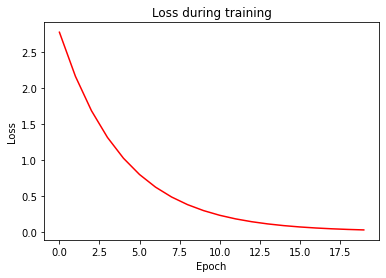

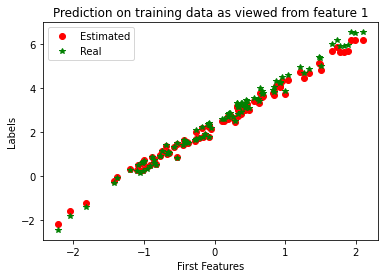

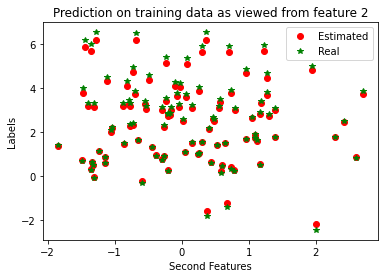

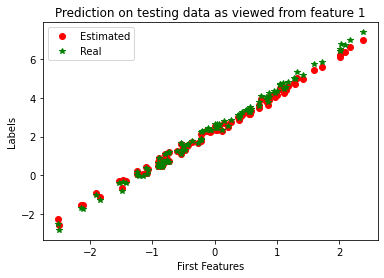

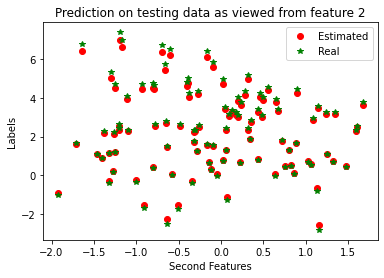

In [12]:
plot(losses)

## Lets look out our weight and bias value after training

In [13]:
print(f'Weight: {weights}')
print(f'Bias: {bias}')

Weight: Parameter containing:
tensor([[ 1.8761],
        [-0.1735]], device='cuda:0', requires_grad=True)
Bias: Parameter containing:
tensor([2.3288], device='cuda:0', requires_grad=True)
